In [7]:
import numpy as np

class Quadcopter:
    def __init__(self):
        # Physical constants
        self.mass = 0.5  # kg
        self.g = 9.81    # gravity
        self.l = 0.225   # arm length (m)
        self.kf = 3e-6   # thrust coefficient
        self.km = 1e-7   # torque coefficient
        self.I = np.diag([5e-3, 5e-3, 1e-2])  # Inertia matrix (kg·m²)

        # State: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
        self.state = np.zeros(12)

    def rotation_matrix(self, phi, theta, psi):
        # Body to world rotation matrix
        Rz = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi),  np.cos(psi), 0],
            [0,            0,           1]
        ])
        Ry = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0,             1, 0],
            [-np.sin(theta), 0, np.cos(theta)]
        ])
        Rx = np.array([
            [1, 0,           0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi),  np.cos(phi)]
        ])
        return Rz @ Ry @ Rx

    def motor_forces_torques(self, omega):
        # omega = motor speeds (rad/s), shape (4,)
        T = self.kf * omega**2  # Thrusts
        total_thrust = np.sum(T)
        # Torques: roll, pitch, yaw
        tau = np.array([
            self.l * (T[0] - T[2]),
            self.l * (T[1] - T[3]),
            self.km * (T[0] - T[1] + T[2] - T[3])
        ])
        return total_thrust, tau

    def step(self, omega, dt):
        x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = self.state
        R = self.rotation_matrix(phi, theta, psi)
        omega_vec = np.array([p, q, r])

        # Forces and torques
        thrust, tau = self.motor_forces_torques(omega)

        # Linear acceleration
        gravity = np.array([0, 0, -self.g])
        thrust_body = np.array([0, 0, thrust / self.mass])
        acc = gravity + R @ thrust_body

        # Angular acceleration
        omega_dot = np.linalg.inv(self.I) @ (tau - np.cross(omega_vec, self.I @ omega_vec))

        # Euler angles derivatives
        E = np.array([
            [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)]
        ])
        euler_dot = E @ omega_vec

        # Integrate state
        new_state = np.zeros(12)
        new_state[0:3] = np.array([x, y, z]) + dt * np.array([vx, vy, vz])
        new_state[3:6] = np.array([vx, vy, vz]) + dt * acc
        new_state[6:9] = np.array([phi, theta, psi]) + dt * euler_dot
        new_state[9:12] = omega_vec + dt * omega_dot

        self.state = new_state
        return self.state


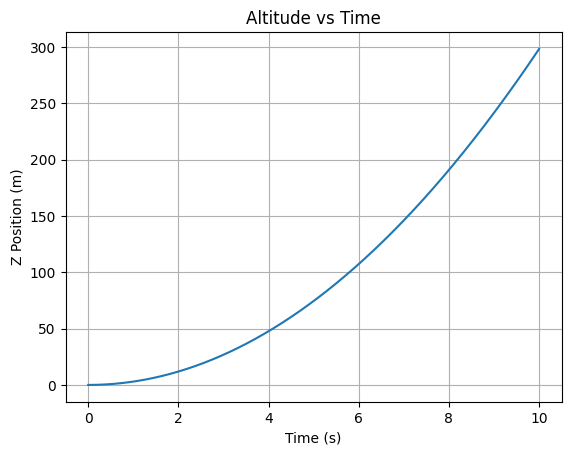

In [8]:
import matplotlib.pyplot as plt

quad = Quadcopter()
dt = 0.01  # time step (s)
th = []
th.append(0)
tl = 0

alth = []
alth.append(0)
for _ in range(1000):
    omega = np.array([400, 400, 400, 400])  # motor speeds (rad/s)
    state = quad.step(omega, dt)
    alth.append(-state[2])
    #print(t, state[0:3])  # print position
    tl += dt
    th.append(tl)

# Plot altitude over time
plt.plot(th, alth)
plt.title("Altitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.grid(True)
plt.show()

In [9]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.prev_error = 0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative


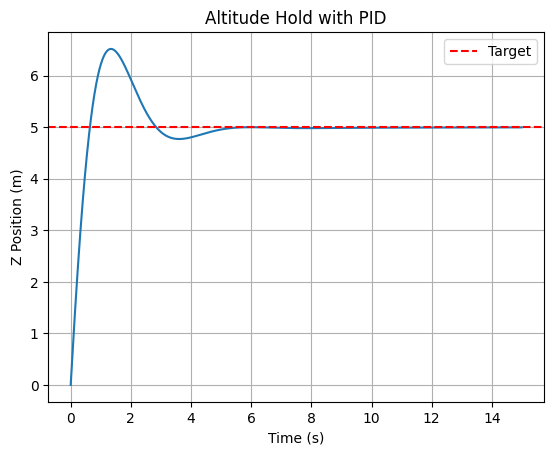

In [30]:
import matplotlib.pyplot as plt

# Initialize quadcopter and PID
quad = Quadcopter()
#pid = PID(kp=2.9, ki=0.2, kd=3.5)
#pid = PID(kp=2.5, ki=0.0, kd=3.25)
pid = PID(kp=3, ki=0.5, kd=2)
#pid = PID(kp=0.6, ki=0.8, kd=1.6)

desired_z = 5.0  # target altitude (meters)
dt = 0.01
time = np.arange(0, 15, dt)
z_history = []

for t in time:
    current_z = quad.state[2]
    vz = quad.state[5]
    error = desired_z - current_z

    # PID computes required total thrust (force)
    u = pid.update(error, dt)
    total_thrust = quad.mass * (quad.g + u)

    # Convert total thrust to motor speeds (assuming all motors equal)
    T_per_motor = total_thrust / 4
    #print(t, error, T_per_motor)
    omega = np.sqrt(T_per_motor / quad.kf) * np.ones(4)

    # Simulate one step
    quad.step(omega, dt)
    z_history.append(quad.state[2])

# Plot altitude over time
plt.plot(time, z_history)
plt.axhline(desired_z, color='r', linestyle='--', label="Target")
plt.title("Altitude Hold with PID")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.grid(True)
plt.show()
